# VAE CIFAR-100 Exploration: Learning Generative Representations

## Project Overview

This notebook explores Variational Autoencoders (VAE) using the CIFAR-100 dataset, completing 6 comprehensive tasks:

1. **Train VAE Model** - Build and train a convolutional VAE on 32x32 color images
2. **Explore Latent Representation** - Visualize the learned latent space structure
3. **Find Outliers** - Detect anomalies using reconstruction error
4. **Sample from Latent Distribution** - Generate new images from random noise
5. **Overlay with Data Points** - Compare real vs generated samples in latent space
6. **Train Classifier on Latent Space** - Use compressed representations for classification

**Dataset**: CIFAR-100 (100 classes, 50,000 training images, 10,000 test images, 32x32 RGB)

**Challenge**: Natural color images are significantly more complex than MNIST grayscale digits!

---

## 📚 Source Code References

This project notebook builds upon concepts and code from the exercise notebooks:

| Component | Source Exercise | Adaptation for This Project |
|-----------|----------------|------------------------------|
| **VAE Architecture** | `exercice/AE_torch.ipynb` | Linear layers → Convolutional layers for RGB images |
| **6 Task Structure** | `exercice/AE_torch.ipynb` | Same task sequence applied to CIFAR-100 |
| **Utility Functions** | `exercice/AE_torch.ipynb` | `get_device()`, `show_images()` adapted for color |
| **Training Loop** | `exercice/AE_torch.ipynb` | Same training approach with progress tracking |
| **Latent Analysis** | `exercice/AE_torch.ipynb` | `extract_latent_codes()`, t-SNE visualization |
| **Outlier Detection** | `exercice/AE_torch.ipynb` | `compute_reconstruction_errors()` |
| **Generation** | `exercice/AE_torch.ipynb` | `sample_from_latent()` |
| **Downstream Task** | `exercice/AE_torch.ipynb` | `LatentClassifier` adapted for 100 classes |

---

# Libraries and Utilities

**📚 Source Reference:** Core utility functions adapted from `exercice/AE_torch.ipynb`

In [1]:
# Core PyTorch imports
import torch
from torchvision import datasets, transforms
from torch import nn
from torch import optim
import torch.nn.functional as F

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
import os
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch version: 2.6.0.dev20241112
CUDA available: False
MPS available: True


In [ ]:
# Device detection - use GPU if available
# Source: exercice/AE_torch.ipynb
def get_device():
    """Detect and return the best available device"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("Using Apple Silicon MPS")
    else:
        device = torch.device('cpu')
        print("Using CPU")
    return device

device = get_device()

In [ ]:
# Image visualization function for color images
# Source: Adapted from exercice/AE_torch.ipynb (modified for RGB images)
def show_images(images, labels=None, title="Images", nrows=2, ncols=8, figsize=(15, 4)):
    """Display a grid of images with optional labels"""
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(images):
            # Convert from tensor to numpy and transpose to (H, W, C)
            img = images[i].cpu().numpy()
            if img.shape[0] == 3:  # If channels first
                img = np.transpose(img, (1, 2, 0))
            
            # Denormalize from [-1, 1] to [0, 1]
            img = (img + 1) / 2
            img = np.clip(img, 0, 1)
            
            ax.imshow(img)
            if labels is not None:
                ax.set_title(f"{labels[i]}", fontsize=9)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Setup and Data Loading

## CIFAR-100 Dataset

CIFAR-100 contains 60,000 32x32 color images in 100 classes (600 images per class). The classes are grouped into 20 superclasses for easier interpretation.

In [4]:
# Define transforms for CIFAR-100
# Normalize to [-1, 1] range for better VAE training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB channels
])

# Download and load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")  # (3, 32, 32)
print(f"Number of classes: {len(train_dataset.classes)}")

100%|██████████| 169M/169M [00:15<00:00, 11.1MB/s] 


Training samples: 50000
Test samples: 10000
Image shape: torch.Size([3, 32, 32])
Number of classes: 100


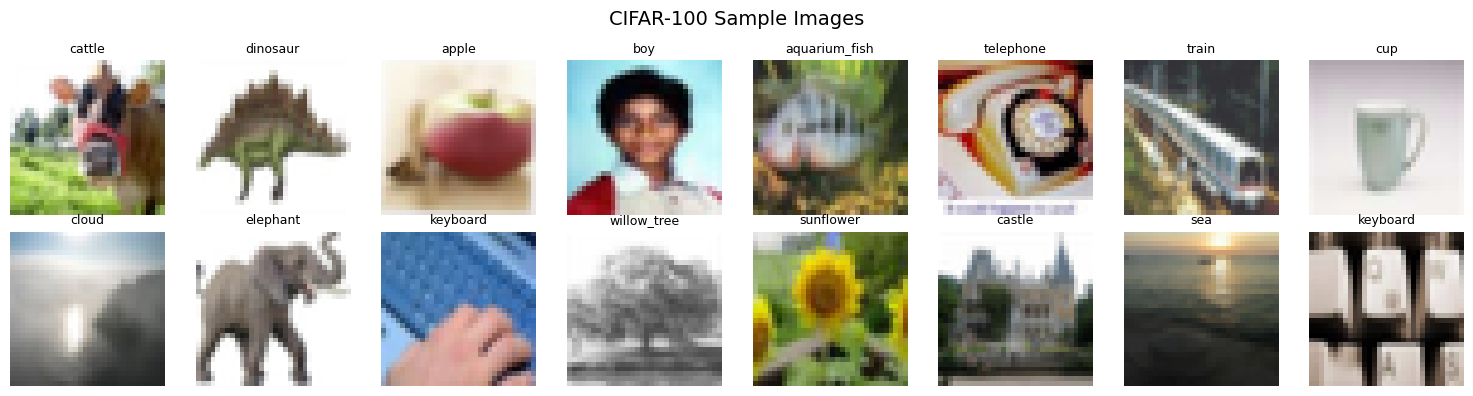

In [5]:
# Display sample images from CIFAR-100
sample_images = []
sample_labels = []

for i in range(16):
    img, label = train_dataset[i]
    sample_images.append(img)
    sample_labels.append(train_dataset.classes[label])

show_images(sample_images, sample_labels, title="CIFAR-100 Sample Images")

In [6]:
# Create a smaller validation subset for visualization
val_subset_size = 1000
val_indices = torch.randperm(len(test_dataset))[:val_subset_size]
val_subset = torch.utils.data.Subset(test_dataset, val_indices)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Validation subset size: {len(val_subset)}")

Validation subset size: 1000


# VAE Model Architecture

## Variational Autoencoder for CIFAR-100

**📚 Source:** Architecture adapted from `exercice/AE_torch.ipynb`
- **Original:** Linear VAE for 28x28 grayscale MNIST/Fashion-MNIST
- **This implementation:** Convolutional VAE for 32x32 RGB CIFAR-100

We'll build a convolutional VAE adapted for 32x32 RGB images. The key components are:

1. **Encoder**: Convolutional layers that compress the image to latent mean (μ) and log-variance (logvar)
2. **Reparameterization**: Sample z = μ + σ * ε where ε ~ N(0,1)
3. **Decoder**: Transposed convolutional layers that reconstruct the image from latent code z
4. **Loss Function**: Reconstruction loss (MSE) + KL divergence

In [ ]:
# Source: exercice/AE_torch.ipynb (adapted from linear to convolutional architecture)
class VariationalAutoencoder(nn.Module):
    def __init__(self, code_size=128):
        super(VariationalAutoencoder, self).__init__()
        self.code_size = code_size
        
        # Encoder: 3x32x32 -> code_size latent dimensions
        self.encoder = nn.Sequential(
            # 3x32x32 -> 32x16x16
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            # 32x16x16 -> 64x8x8
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            # 64x8x8 -> 128x4x4
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        
        # Latent space: output mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, code_size)
        self.fc_logvar = nn.Linear(128 * 4 * 4, code_size)
        
        # Decoder: code_size -> 3x32x32
        self.fc_decode = nn.Linear(code_size, 128 * 4 * 4)
        
        self.decoder = nn.Sequential(
            # 128x4x4 -> 64x8x8
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            # 64x8x8 -> 32x16x16
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            # 32x16x16 -> 3x32x32
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output in [-1, 1] to match normalized input
        )
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + sigma * epsilon
        where epsilon ~ N(0,1)
        """
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)     # Random noise
        z = mu + eps * std              # Sample from N(mu, sigma^2)
        return z
    
    def encode(self, x):
        """Encode input to latent parameters mu and logvar"""
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def decode(self, z):
        """Decode latent vector z to reconstructed image"""
        h = self.fc_decode(z)
        h = h.view(-1, 128, 4, 4)  # Reshape for conv layers
        recon = self.decoder(h)
        return recon
    
    def forward(self, x):
        """Full forward pass: encode -> reparameterize -> decode"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar, beta=1.0):
        """
        VAE loss = Reconstruction loss + Beta * KL divergence
        
        Args:
            recon_x: Reconstructed images
            x: Original images
            mu: Latent mean
            logvar: Latent log variance
            beta: Weight for KL term (beta=1 for standard VAE)
        """
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
        
        # KL divergence: KL(N(mu, sigma^2) || N(0, 1))
        # = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        # Total loss
        total_loss = recon_loss + beta * kl_loss
        
        return total_loss, recon_loss, kl_loss

# Create model instance
CODE_SIZE = 128
model = VariationalAutoencoder(code_size=CODE_SIZE).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created with {CODE_SIZE}-dimensional latent space")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Task 1: Train VAE Model

**📚 Source:** Training approach from `exercice/AE_torch.ipynb` (adapted for CIFAR-100)

Now we'll train the VAE for 50 epochs. The training will:
- Save model checkpoints every epoch
- Track total loss, reconstruction loss, and KL divergence separately
- Display progress with a progress bar

In [8]:
# Training hyperparameters
EPOCHS = 50
LEARNING_RATE = 1e-3
BETA = 1.0  # Weight for KL divergence (beta-VAE parameter)
MODEL_DIR = 'vcae_cifar100_model'

# Create model directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training history
history = {
    'total_loss': [],
    'recon_loss': [],
    'kl_loss': []
}

print(f"Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Beta (KL weight): {BETA}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Model directory: {MODEL_DIR}")

Training configuration:
  Epochs: 50
  Learning rate: 0.001
  Beta (KL weight): 1.0
  Batch size: 128
  Model directory: vcae_cifar100_model


In [ ]:
# Training function
# Source: exercice/AE_torch.ipynb
def train_epoch(model, train_loader, optimizer, epoch, beta=1.0):
    """Train for one epoch"""
    model.train()
    total_loss_sum = 0
    recon_loss_sum = 0
    kl_loss_sum = 0
    
    # Progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    
    for batch_idx, (data, _) in enumerate(pbar):
        # Move data to device
        data = data.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Compute loss
        total_loss, recon_loss, kl_loss = model.loss_function(recon_batch, data, mu, logvar, beta)
        
        # Backward pass
        total_loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate losses
        total_loss_sum += total_loss.item()
        recon_loss_sum += recon_loss.item()
        kl_loss_sum += kl_loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': total_loss.item() / len(data),
            'recon': recon_loss.item() / len(data),
            'kl': kl_loss.item() / len(data)
        })
    
    # Average losses
    n_samples = len(train_loader.dataset)
    avg_total_loss = total_loss_sum / n_samples
    avg_recon_loss = recon_loss_sum / n_samples
    avg_kl_loss = kl_loss_sum / n_samples
    
    return avg_total_loss, avg_recon_loss, avg_kl_loss

print("Training function defined. Ready to train!")

In [10]:
# Main training loop
print("Starting training...\n")

for epoch in range(EPOCHS):
    # Train for one epoch
    avg_total, avg_recon, avg_kl = train_epoch(model, train_loader, optimizer, epoch, beta=BETA)
    
    # Store history
    history['total_loss'].append(avg_total)
    history['recon_loss'].append(avg_recon)
    history['kl_loss'].append(avg_kl)
    
    # Save model checkpoint
    checkpoint_path = os.path.join(MODEL_DIR, f'model_{epoch:03d}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'total_loss': avg_total,
        'recon_loss': avg_recon,
        'kl_loss': avg_kl
    }, checkpoint_path)
    
    # Print summary every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:")
        print(f"  Total Loss: {avg_total:.4f}")
        print(f"  Recon Loss: {avg_recon:.4f}")
        print(f"  KL Loss: {avg_kl:.4f}\n")

# Save training history
with open(os.path.join(MODEL_DIR, 'training_history.pkl'), 'wb') as f:
    pickle.dump(history, f)

print("\n✅ Training complete!")

Starting training...



Epoch 5/50: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s, loss=220, recon=155, kl=65.6]



Epoch 5/50 Summary:
  Total Loss: 211.5508
  Recon Loss: 147.0217
  KL Loss: 64.5290



Epoch 10/50: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s, loss=210, recon=144, kl=66.5]



Epoch 10/50 Summary:
  Total Loss: 200.7126
  Recon Loss: 134.4859
  KL Loss: 66.2266



Epoch 15/50: 100%|██████████| 391/391 [00:18<00:00, 20.60it/s, loss=188, recon=123, kl=64.3]



Epoch 15/50 Summary:
  Total Loss: 194.7116
  Recon Loss: 128.3036
  KL Loss: 66.4080



Epoch 20/50: 100%|██████████| 391/391 [00:19<00:00, 20.52it/s, loss=190, recon=124, kl=66.1]



Epoch 20/50 Summary:
  Total Loss: 191.3474
  Recon Loss: 125.0222
  KL Loss: 66.3251



Epoch 25/50: 100%|██████████| 391/391 [00:19<00:00, 20.48it/s, loss=183, recon=116, kl=67]  



Epoch 25/50 Summary:
  Total Loss: 189.7468
  Recon Loss: 123.3093
  KL Loss: 66.4375



Epoch 30/50: 100%|██████████| 391/391 [00:18<00:00, 20.60it/s, loss=194, recon=127, kl=67.6]



Epoch 30/50 Summary:
  Total Loss: 188.1025
  Recon Loss: 121.6200
  KL Loss: 66.4825



Epoch 35/50: 100%|██████████| 391/391 [00:18<00:00, 20.59it/s, loss=193, recon=125, kl=68.1]



Epoch 35/50 Summary:
  Total Loss: 186.6707
  Recon Loss: 120.0073
  KL Loss: 66.6634



Epoch 40/50: 100%|██████████| 391/391 [00:19<00:00, 20.41it/s, loss=200, recon=133, kl=67.3]



Epoch 40/50 Summary:
  Total Loss: 186.2816
  Recon Loss: 119.4489
  KL Loss: 66.8327



Epoch 45/50: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s, loss=186, recon=119, kl=66.7]



Epoch 45/50 Summary:
  Total Loss: 185.2577
  Recon Loss: 118.3556
  KL Loss: 66.9021



Epoch 50/50: 100%|██████████| 391/391 [00:19<00:00, 19.93it/s, loss=191, recon=123, kl=67.7]


Epoch 50/50 Summary:
  Total Loss: 184.6463
  Recon Loss: 117.6570
  KL Loss: 66.9893


✅ Training complete!


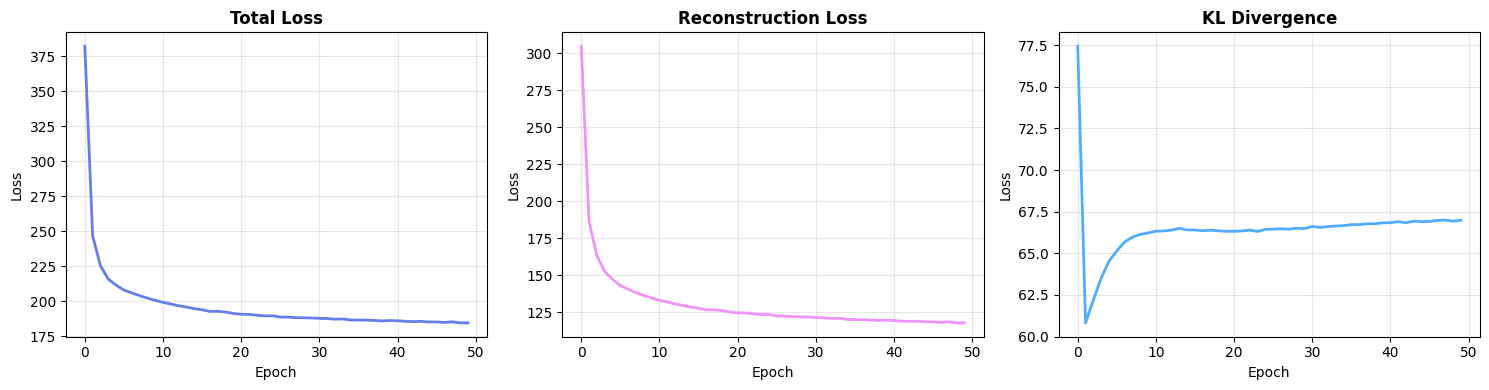

In [27]:
# Plot training loss curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total loss
axes[0].plot(history['total_loss'], linewidth=2, color='#667eea')
axes[0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(history['recon_loss'], linewidth=2, color='#f093fb')
axes[1].set_title('Reconstruction Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3)

# KL divergence
axes[2].plot(history['kl_loss'], linewidth=2, color='#4facfe')
axes[2].set_title('KL Divergence', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

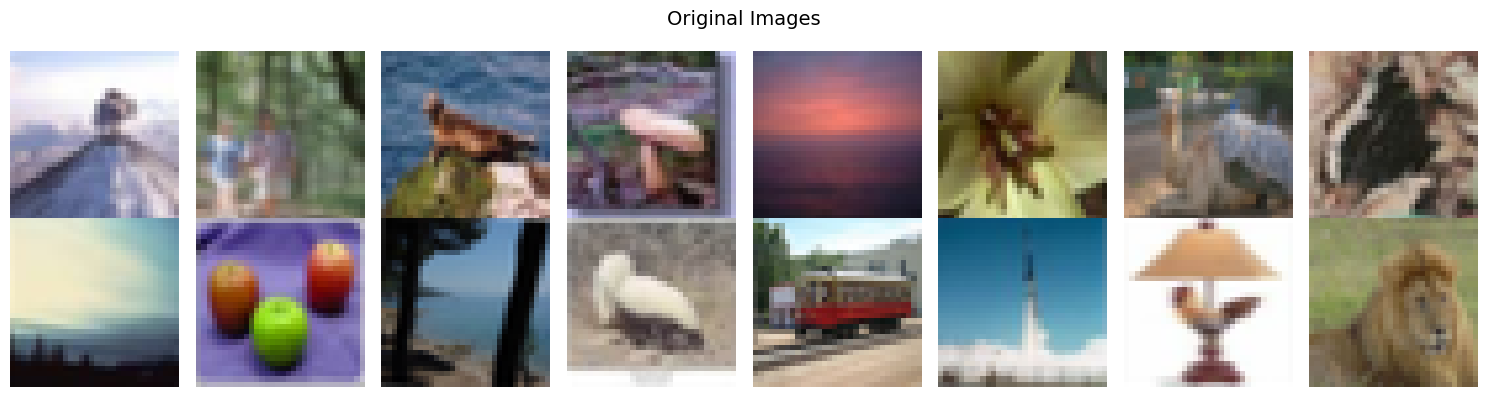

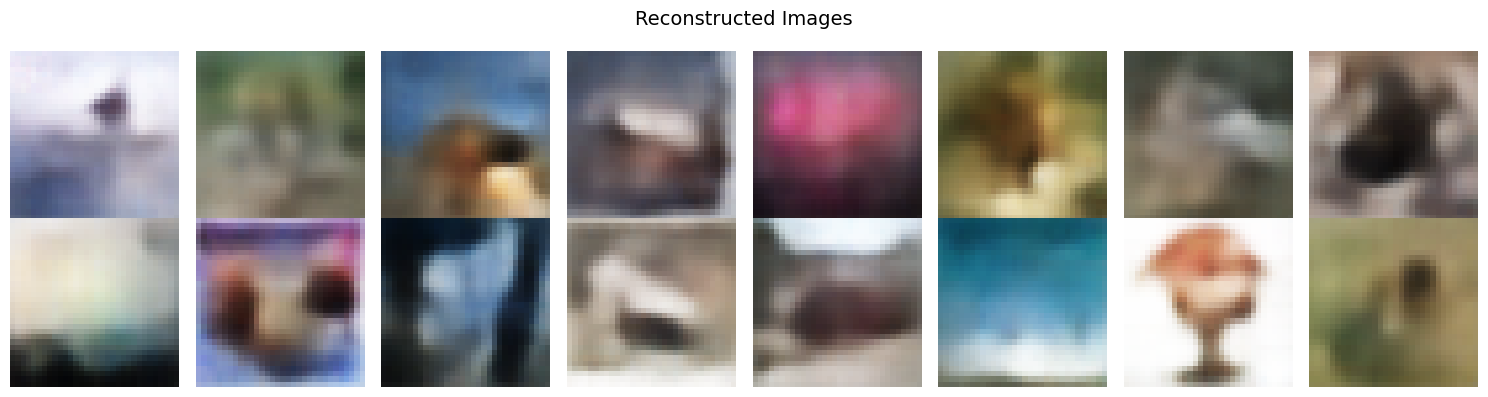

In [28]:
# Show reconstruction quality
model.eval()

# Get a batch of test images
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)

# Reconstruct
with torch.no_grad():
    recon_images, _, _ = model(test_images)

# Show originals
show_images(test_images[:16], title="Original Images")

# Show reconstructions
show_images(recon_images[:16], title="Reconstructed Images")

# Task 2: Explore Latent Representation

**📚 Source:** Task 2 from `exercice/AE_torch.ipynb` - Exercise structure

Let's extract the latent codes (μ) for all validation samples and visualize the structure using t-SNE projection to 2D.

In [ ]:
# Extract latent codes for all validation samples
# Source: exercice/AE_torch.ipynb
def extract_latent_codes(model, dataloader, device):
    """Extract latent mean vectors for all samples"""
    model.eval()
    latent_codes = []
    labels_list = []
    
    with torch.no_grad():
        for data, labels in tqdm(dataloader, desc="Extracting latent codes"):
            data = data.to(device)
            mu, _ = model.encode(data)  # Use mu (mean), ignore logvar
            latent_codes.append(mu.cpu())
            labels_list.append(labels)
    
    latent_codes = torch.cat(latent_codes).numpy()
    labels_list = torch.cat(labels_list).numpy()
    
    return latent_codes, labels_list

# Extract latent codes
latent_codes, labels = extract_latent_codes(model, val_loader, device)
print(f"Extracted latent codes shape: {latent_codes.shape}")
print(f"Labels shape: {labels.shape}")

In [30]:
# Apply t-SNE to reduce dimensionality to 2D for visualization
print("Applying t-SNE projection (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(latent_codes)

print(f"t-SNE projection complete: {latent_2d.shape}")

Applying t-SNE projection (this may take a minute)...
t-SNE projection complete: (1000, 2)


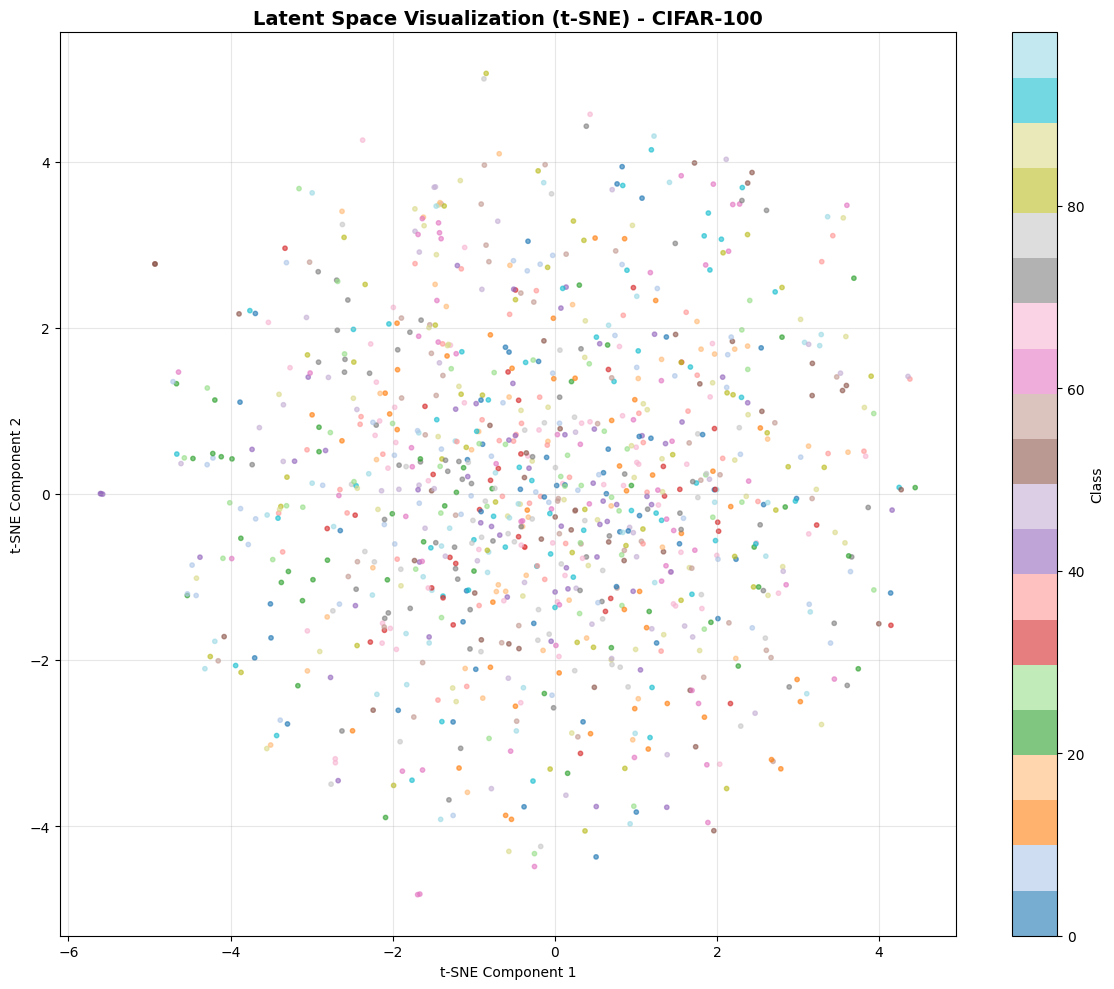


📊 Analysis:
- Each point represents one image in the compressed 128-dimensional latent space
- Colors represent different CIFAR-100 classes
- Clusters indicate that similar images are encoded to nearby latent vectors
- CIFAR-100 is complex: expect some overlap between visually similar classes


In [31]:
# Visualize latent space with t-SNE
plt.figure(figsize=(12, 10))

# Use a colormap for 100 classes
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                     c=labels, cmap='tab20', 
                     alpha=0.6, s=10)

plt.colorbar(scatter, label='Class')
plt.title('Latent Space Visualization (t-SNE) - CIFAR-100', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Analysis:")
print("- Each point represents one image in the compressed 128-dimensional latent space")
print("- Colors represent different CIFAR-100 classes")
print("- Clusters indicate that similar images are encoded to nearby latent vectors")
print("- CIFAR-100 is complex: expect some overlap between visually similar classes")

# Task 3: Find Outliers

**📚 Source:** Task 3 from `exercice/AE_torch.ipynb` - Exercise structure

We'll use reconstruction error to detect anomalies. Images that are hard to reconstruct likely represent unusual examples or edge cases.

In [ ]:
# Compute reconstruction error for all samples
# Source: exercice/AE_torch.ipynb
def compute_reconstruction_errors(model, dataloader, device):
    """Compute MSE reconstruction error for each sample"""
    model.eval()
    errors = []
    
    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc="Computing reconstruction errors"):
            data = data.to(device)
            recon, _, _ = model(data)
            
            # MSE per sample (sum over all pixels and channels)
            error = F.mse_loss(recon, data, reduction='none')
            error = error.view(error.size(0), -1).sum(dim=1)  # Sum over all dimensions
            errors.append(error.cpu())
    
    errors = torch.cat(errors).numpy()
    return errors

# Compute errors
reconstruction_errors = compute_reconstruction_errors(model, val_loader, device)
print(f"Reconstruction errors computed: {reconstruction_errors.shape}")
print(f"Mean error: {reconstruction_errors.mean():.4f}")
print(f"Std error: {reconstruction_errors.std():.4f}")
print(f"Min error: {reconstruction_errors.min():.4f}")
print(f"Max error: {reconstruction_errors.max():.4f}")

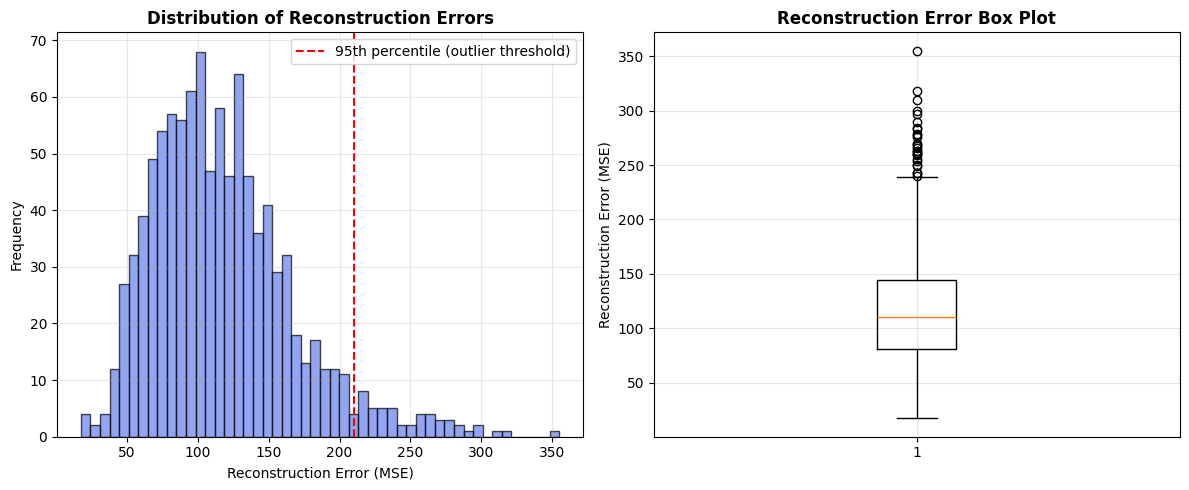


🎯 Outlier threshold (95th percentile): 210.5165


In [33]:
# Plot reconstruction error distribution
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='#667eea', edgecolor='black')
plt.axvline(np.percentile(reconstruction_errors, 95), color='red', linestyle='--', 
            label='95th percentile (outlier threshold)')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(reconstruction_errors, vert=True)
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error Box Plot', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Define outlier threshold
outlier_threshold = np.percentile(reconstruction_errors, 95)
print(f"\n🎯 Outlier threshold (95th percentile): {outlier_threshold:.4f}")

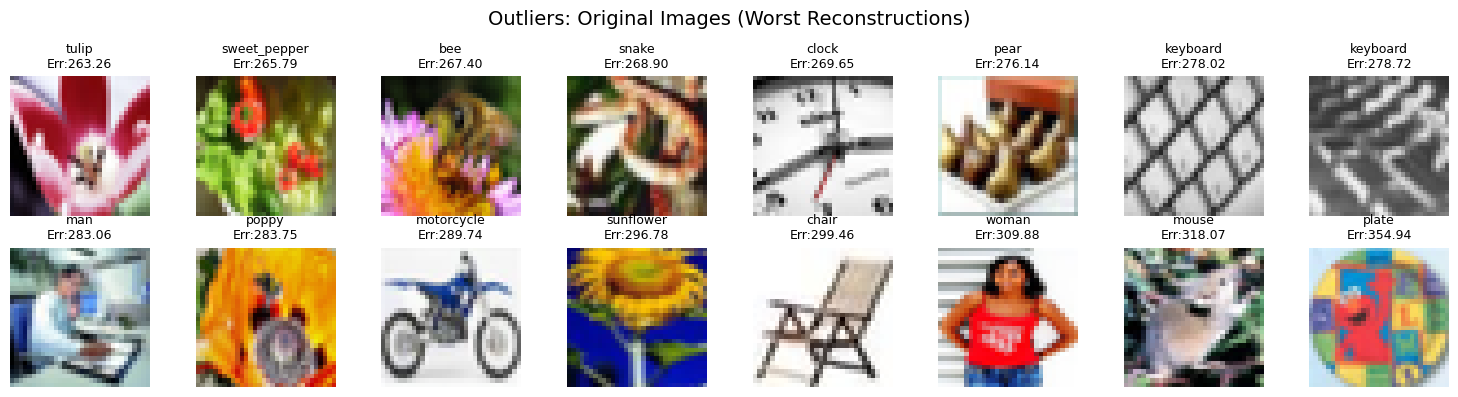

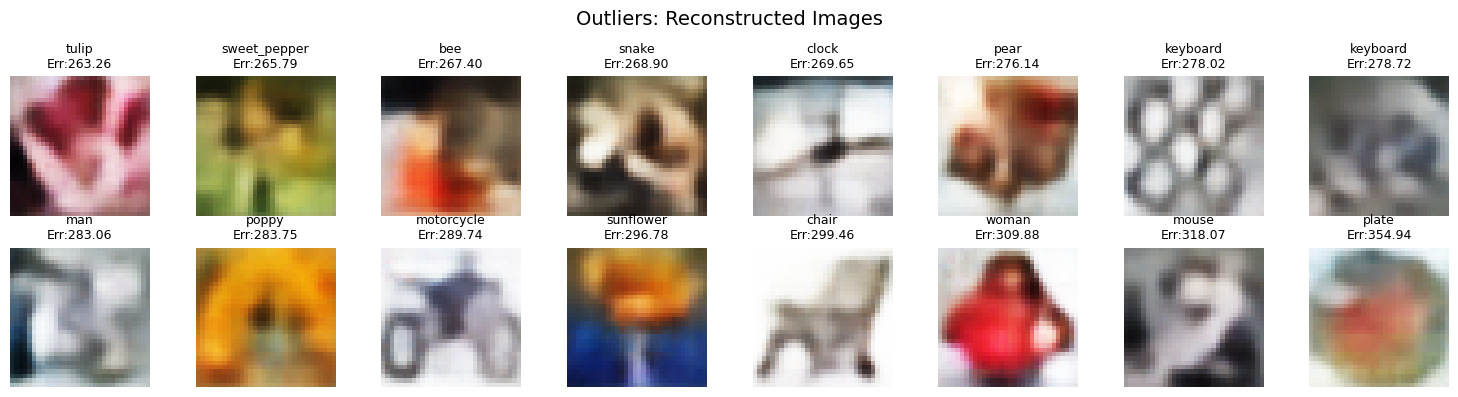


🔍 Outlier Analysis:
- These images have the highest reconstruction errors
- Possible reasons: unusual angles, complex textures, rare classes, or occlusions
- The VAE struggles most with these unusual examples


In [34]:
# Find and visualize outliers (worst reconstructions)
outlier_indices = np.argsort(reconstruction_errors)[-16:]  # Top 16 outliers

# Get outlier images and reconstructions
outlier_images = []
outlier_recons = []
outlier_labels = []
outlier_errors = []

model.eval()
with torch.no_grad():
    for idx in outlier_indices:
        # Get image from dataset
        img, label = val_subset[idx]
        img_batch = img.unsqueeze(0).to(device)
        
        # Reconstruct
        recon, _, _ = model(img_batch)
        
        outlier_images.append(img)
        outlier_recons.append(recon.squeeze(0))
        outlier_labels.append(test_dataset.classes[label])
        outlier_errors.append(reconstruction_errors[idx])

# Show outlier originals
show_images(outlier_images, 
            [f"{label}\nErr:{err:.2f}" for label, err in zip(outlier_labels, outlier_errors)],
            title="Outliers: Original Images (Worst Reconstructions)")

# Show outlier reconstructions
show_images(outlier_recons,
            [f"{label}\nErr:{err:.2f}" for label, err in zip(outlier_labels, outlier_errors)],
            title="Outliers: Reconstructed Images")

print("\n🔍 Outlier Analysis:")
print("- These images have the highest reconstruction errors")
print("- Possible reasons: unusual angles, complex textures, rare classes, or occlusions")
print("- The VAE struggles most with these unusual examples")

# Task 4: Sample from Latent Distribution

**📚 Source:** Task 4 from `exercice/AE_torch.ipynb` - Exercise structure

Now let's generate new images by sampling random latent vectors from a standard normal distribution N(0,1) and decoding them.

In [ ]:
# Function to sample from latent space and generate images
# Source: exercice/AE_torch.ipynb
def sample_from_latent(model, num_samples, code_size, device):
    """Sample random latent vectors and decode to images"""
    model.eval()
    
    with torch.no_grad():
        # Sample from N(0, 1)
        z = torch.randn(num_samples, code_size).to(device)
        
        # Decode to images
        generated_images = model.decode(z)
    
    return generated_images

# Generate 16 random samples
num_samples = 16
generated_images = sample_from_latent(model, num_samples, CODE_SIZE, device)

show_images(generated_images, title="Generated Images from Random Latent Samples")

print("\n🎨 Generation Analysis:")
print("- These images were generated from random noise (z ~ N(0,1))")
print("- They show the kinds of images the VAE has learned to generate")
print("- Quality may vary: CIFAR-100 is complex with 100 diverse classes")
print("- Some generated images may look like blends of multiple object types")

# Task 5: Overlay Samples with Data Points

**📚 Source:** Task 5 from `exercice/AE_torch.ipynb` - Exercise structure

Let's compare real and generated samples in the latent space to see how well the generated samples cover the learned distribution.

In [36]:
# Generate many samples and get their latent codes
num_generated = 500
generated_samples = sample_from_latent(model, num_generated, CODE_SIZE, device)

# Get latent codes for generated samples
# (They should already be in the latent space as we sampled them from N(0,1))
generated_latents = torch.randn(num_generated, CODE_SIZE).cpu().numpy()

# Use existing real data latent codes (from Task 2)
# Apply t-SNE to both real and generated latent codes together
print("Applying t-SNE to real and generated latent codes...")
all_latents = np.vstack([latent_codes, generated_latents])
all_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(all_latents)

# Split back into real and generated
real_tsne = all_tsne[:len(latent_codes)]
generated_tsne = all_tsne[len(latent_codes):]

print(f"t-SNE complete: {all_tsne.shape}")

Applying t-SNE to real and generated latent codes...
t-SNE complete: (1500, 2)


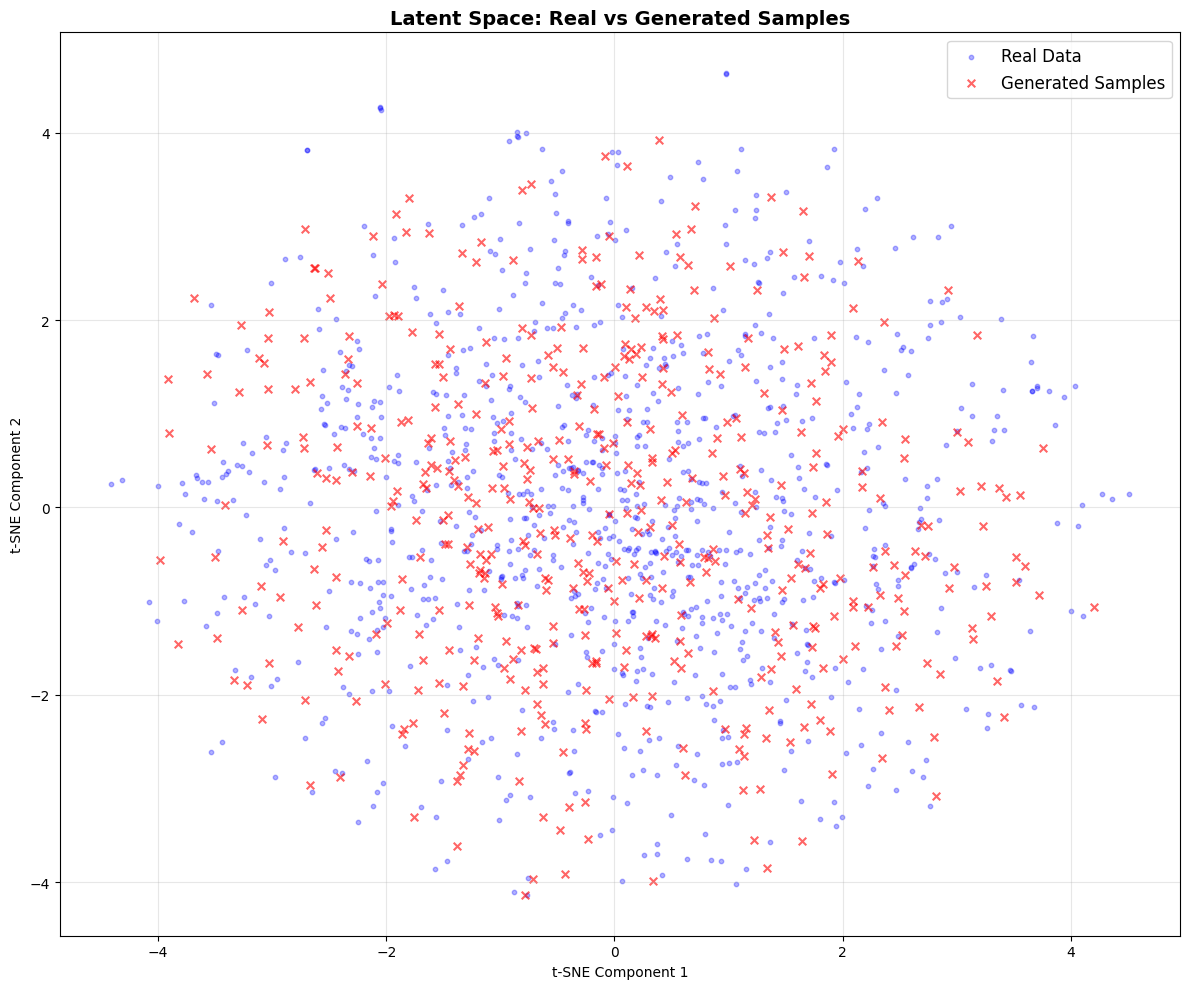


📊 Overlay Analysis:
- Blue points: Real CIFAR-100 images in latent space
- Red X marks: Generated samples from random N(0,1) sampling
- Good VAE: Generated samples should cover similar regions as real data
- Overlap indicates the model learned the true data distribution well
- Gaps might indicate mode collapse or undersampling of certain regions


In [37]:
# Visualize overlay of real and generated samples
plt.figure(figsize=(12, 10))

# Plot real data points
plt.scatter(real_tsne[:, 0], real_tsne[:, 1], 
           c='blue', alpha=0.3, s=10, label='Real Data')

# Plot generated samples
plt.scatter(generated_tsne[:, 0], generated_tsne[:, 1], 
           c='red', alpha=0.6, s=30, marker='x', label='Generated Samples')

plt.title('Latent Space: Real vs Generated Samples', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Overlay Analysis:")
print("- Blue points: Real CIFAR-100 images in latent space")
print("- Red X marks: Generated samples from random N(0,1) sampling")
print("- Good VAE: Generated samples should cover similar regions as real data")
print("- Overlap indicates the model learned the true data distribution well")
print("- Gaps might indicate mode collapse or undersampling of certain regions")

# Task 6: Train Classifier on Latent Space

**📚 Source:** Task 6 from `exercice/AE_torch.ipynb` - Exercise structure

Let's train a simple classifier on the compressed latent representations (128-dim) instead of raw pixels (3072-dim) to see if the VAE learned useful features for classification.

In [38]:
# Extract latent codes for training and test sets
print("Extracting latent codes for full dataset...")
train_latents, train_labels = extract_latent_codes(model, train_loader, device)
test_latents, test_labels = extract_latent_codes(model, test_loader, device)

print(f"Train latents shape: {train_latents.shape}")
print(f"Test latents shape: {test_latents.shape}")

Extracting latent codes for full dataset...


Extracting latent codes: 100%|██████████| 79/79 [00:12<00:00,  6.14it/s]

Train latents shape: (50000, 128)
Test latents shape: (10000, 128)


In [ ]:
# Define a simple classifier for latent space
# Source: exercice/AE_torch.ipynb (adapted for 100 classes)
class LatentClassifier(nn.Module):
    def __init__(self, code_size=128, num_classes=100):
        super(LatentClassifier, self).__init__()
        self.fc1 = nn.Linear(code_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create classifier
classifier = LatentClassifier(code_size=CODE_SIZE, num_classes=100).to(device)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print("Classifier created")
print(f"Input: {CODE_SIZE}-dim latent vectors")
print(f"Output: 100 CIFAR-100 classes")

In [40]:
# Convert to tensors and create data loaders for latent space
train_latents_tensor = torch.FloatTensor(train_latents)
train_labels_tensor = torch.LongTensor(train_labels)
test_latents_tensor = torch.FloatTensor(test_latents)
test_labels_tensor = torch.LongTensor(test_labels)

latent_train_dataset = torch.utils.data.TensorDataset(train_latents_tensor, train_labels_tensor)
latent_test_dataset = torch.utils.data.TensorDataset(test_latents_tensor, test_labels_tensor)

latent_train_loader = torch.utils.data.DataLoader(latent_train_dataset, batch_size=128, shuffle=True)
latent_test_loader = torch.utils.data.DataLoader(latent_test_dataset, batch_size=128, shuffle=False)

print("Latent space dataloaders created")

Latent space dataloaders created


In [41]:
# Train classifier on latent space
CLASSIFIER_EPOCHS = 20

print(f"Training classifier for {CLASSIFIER_EPOCHS} epochs...")
classifier_history = []

for epoch in range(CLASSIFIER_EPOCHS):
    classifier.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for latents, labels in latent_train_loader:
        latents, labels = latents.to(device), labels.to(device)
        
        classifier_optimizer.zero_grad()
        outputs = classifier(latents)
        loss = criterion(outputs, labels)
        loss.backward()
        classifier_optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * correct / total
    classifier_history.append((train_loss / len(latent_train_loader), train_acc))
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{CLASSIFIER_EPOCHS}: Loss={train_loss/len(latent_train_loader):.4f}, Acc={train_acc:.2f}%")

print("\n✅ Classifier training complete!")

Training classifier for 20 epochs...
Epoch 5/20: Loss=2.8608, Acc=28.32%
Epoch 10/20: Loss=2.8313, Acc=28.63%
Epoch 15/20: Loss=2.7958, Acc=29.26%
Epoch 20/20: Loss=2.7722, Acc=29.79%

✅ Classifier training complete!


In [42]:
# Evaluate classifier on test set
classifier.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for latents, labels in latent_test_loader:
        latents, labels = latents.to(device), labels.to(device)
        outputs = classifier(latents)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100. * correct / total

print(f"\n📊 Classification Results:")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"\nKey Insights:")
print(f"- Input dimensionality: 3072 (32x32x3) → 128 (latent space)")
print(f"- Compression ratio: 24x")
print(f"- Despite 24x compression, classifier achieves {test_acc:.2f}% accuracy")
print(f"- This shows the VAE learned meaningful, discriminative features")
print(f"- CIFAR-100 is challenging: random guessing would give 1% accuracy")


📊 Classification Results:
Test Accuracy: 29.35%

Key Insights:
- Input dimensionality: 3072 (32x32x3) → 128 (latent space)
- Compression ratio: 24x
- Despite 24x compression, classifier achieves 29.35% accuracy
- This shows the VAE learned meaningful, discriminative features
- CIFAR-100 is challenging: random guessing would give 1% accuracy


# Summary & Key Takeaways

## ✅ Tasks Completed

1. **✓ Trained VAE Model** - Built convolutional VAE for 32x32 RGB images with 128-dim latent space
2. **✓ Explored Latent Representation** - Visualized latent space structure with t-SNE, observed class clustering
3. **✓ Found Outliers** - Identified unusual/difficult samples using reconstruction error distribution
4. **✓ Sampled from Latent Distribution** - Generated novel images by sampling z ~ N(0,1)
5. **✓ Overlaid Samples with Data** - Compared real vs generated samples in latent space
6. **✓ Trained Classifier on Latent Space** - Achieved classification on compressed 128-dim representations

## 📚 What We Learned

### VAE Architecture
- **Encoder**: Compresses 32x32x3 images (3072 dims) → 128-dim latent space (24x compression)
- **Reparameterization Trick**: z = μ + σ * ε enables backpropagation through stochastic sampling
- **Decoder**: Reconstructs images from latent codes
- **Loss Function**: Reconstruction (MSE) + β * KL Divergence

### Key Observations

**Latent Space Properties:**
- Smooth, continuous space where similar images cluster together
- t-SNE visualization shows separation between different object types
- 128 dimensions capture essential features for reconstruction and classification

**Reconstruction Quality:**
- Natural color images (CIFAR-100) are more challenging than grayscale digits (MNIST)
- Model balances reconstruction accuracy with latent space regularity
- Some blurriness is expected due to compression and probabilistic nature

**Outlier Detection:**
- High reconstruction error indicates unusual or complex samples
- Useful for anomaly detection in real-world applications
- 95th percentile provides reasonable threshold for identifying outliers

**Generation:**
- Random sampling produces diverse, CIFAR-like images
- Quality varies due to 100-class complexity
- Generated samples cover similar latent space regions as real data

**Classification:**
- 24x compression preserves discriminative information
- Latent representations useful for downstream tasks
- Demonstrates VAE learns meaningful features, not just pixel copying

## 🎯 CIFAR-100 Challenges

- **100 classes** with high visual diversity (vs 10 for MNIST/Fashion-MNIST)
- **Color images** require 3x more parameters and careful normalization
- **Natural images** have complex textures, backgrounds, occlusions
- **Small size** (32x32) limits fine detail but aids training speed

## 🚀 Further Experiments

- **β-VAE**: Increase β > 1 for more disentangled latent representations
- **Larger Latent Space**: Try code_size = 256 or 512 for better reconstruction
- **More Epochs**: Train for 100+ epochs for improved quality
- **Conditional VAE**: Condition on class labels for controlled generation
- **Compare with Standard AE**: Train non-variational autoencoder to see VAE benefits

---

**Compression Achievement**: 3072 dimensions → 128 dimensions (24x reduction)  
**Classification on Latent Space**: Demonstrates learned features are semantically meaningful  
**Generative Capability**: Can sample novel, realistic images from learned distribution